In [1]:
from ipynb.fs.full.tokyo_NLP import *

/Users/karthikmahendra/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


station is repeated 3579 times.
tokyo is repeated 2399 times.
room is repeated 2276 times.
shinjuku is repeated 1663 times.
line is repeated 1320 times.
minutes is repeated 1234 times.
house is repeated 1116 times.
min is repeated 1049 times.
walk is repeated 980 times.
asakusa is repeated 837 times.
bed is repeated 819 times.
jr is repeated 788 times.
area is repeated 785 times.
airport is repeated 763 times.
apartment is repeated 726 times.
mins is repeated 721 times.
ikebukuro is repeated 720 times.
access is repeated 687 times.
shibuya is repeated 640 times.
rooms is repeated 629 times.
restaurants is repeated 585 times.
kitchen is repeated 580 times.
shopping is repeated 579 times.
stores is repeated 577 times.
ueno is repeated 569 times.
hotel is repeated 568 times.
convenience is repeated 506 times.
akihabara is repeated 501 times.
train is repeated 477 times.
floor is repeated 477 times.
haneda is repeated 477 times.
bathroom is repeated 466 times.
ginza is repeated 445 times.


<Figure size 1200x1200 with 1 Axes>

In [4]:
listings_clean = listings_clean.drop(columns = ['summary','KW',],axis=1)

In [10]:
list(listings_clean.columns)

['host_is_superhost',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'host_active',
 'hot_tub',
 'wifi',
 'ac',
 'kitchen',
 'washer',
 'tv',
 'intercom',
 'heating',
 'kid_friendly',
 'dryer',
 'smoke_detector',
 'cm_detector',
 'fire_extinguisher',
 'essentials',
 'shampoo',
 'hangers',
 'hair_dryer',
 'iron',
 'workspace',
 'self_check_in',
 'lockbox',
 'dishware',
 'safety_card',
 'shades',
 'hot_water',
 'bed_linens',
 'microwave',
 'coffee_maker',
 'refrigerator',
 'cooking_basics',
 'stove',
 'patio_or_balcony',
 'long_term',
 'no_stairs',
 'first_aid',
 'twenty_four_hour',
 'private_entrance',
 'luggage_dropoff',
 'well_lit',
 'ot

In [5]:
df = pd.get_dummies(listings_clean)

In [6]:
df.shape

(11995, 161)

In [7]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [8]:
to_drop 

[]

In [13]:
numerical_col = ['accommodates','bathrooms','bedrooms','security_deposit','guests_included','extra_people',
                 'cleaning_fee','maximum_nights','host_active',
                'minimum_nights','price']

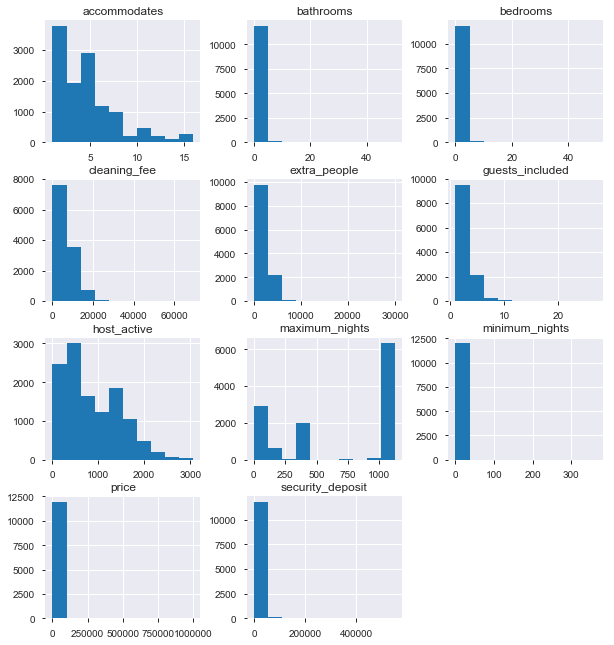

In [14]:
df[numerical_col].hist(figsize=(10,11));

In [15]:
# Log transforming columns because some features are highly skewed. 
numerical_col = [i for i in numerical_col if i not in ['accommodates','host_active']] # Removing items not to be transformed

for col in numerical_col:
        df[col] = df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
        df[col] = np.log(df[col])

In [16]:
#Target
y_price = df['price']
X_price = df.drop('price', axis=1)

In [17]:
# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_price = pd.DataFrame(scaler.fit_transform(X_price), columns=list(X_price.columns))

In [18]:
from sklearn.model_selection import train_test_split
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(
                                                           X_price, y_price, test_size=0.2, random_state=42)

In [19]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train_price, y_train_price)
training_preds_xgb_reg = xgb_reg.predict(X_train_price)
val_preds_xgb_reg = xgb_reg.predict(X_test_price)

print("\nTraining MSE:", round(mean_squared_error(y_train_price, training_preds_xgb_reg),3))
print("Validation MSE:", round(mean_squared_error(y_test_price, val_preds_xgb_reg),3))

[00:14:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training MSE: 0.316
Validation MSE: 0.281


In [20]:
print("\nTraining r2:", round(r2_score(y_train_price, training_preds_xgb_reg),3))
print("Validation r2:", round(r2_score(y_test_price, val_preds_xgb_reg),3))


Training r2: 0.605
Validation r2: 0.61


In [21]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train_price.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
#ft_weights_xgb_reg

In [22]:
# Drop feature weights of 0 
ft_weights_xgb_reg = ft_weights_xgb_reg[(ft_weights_xgb_reg != 0).all(1)]

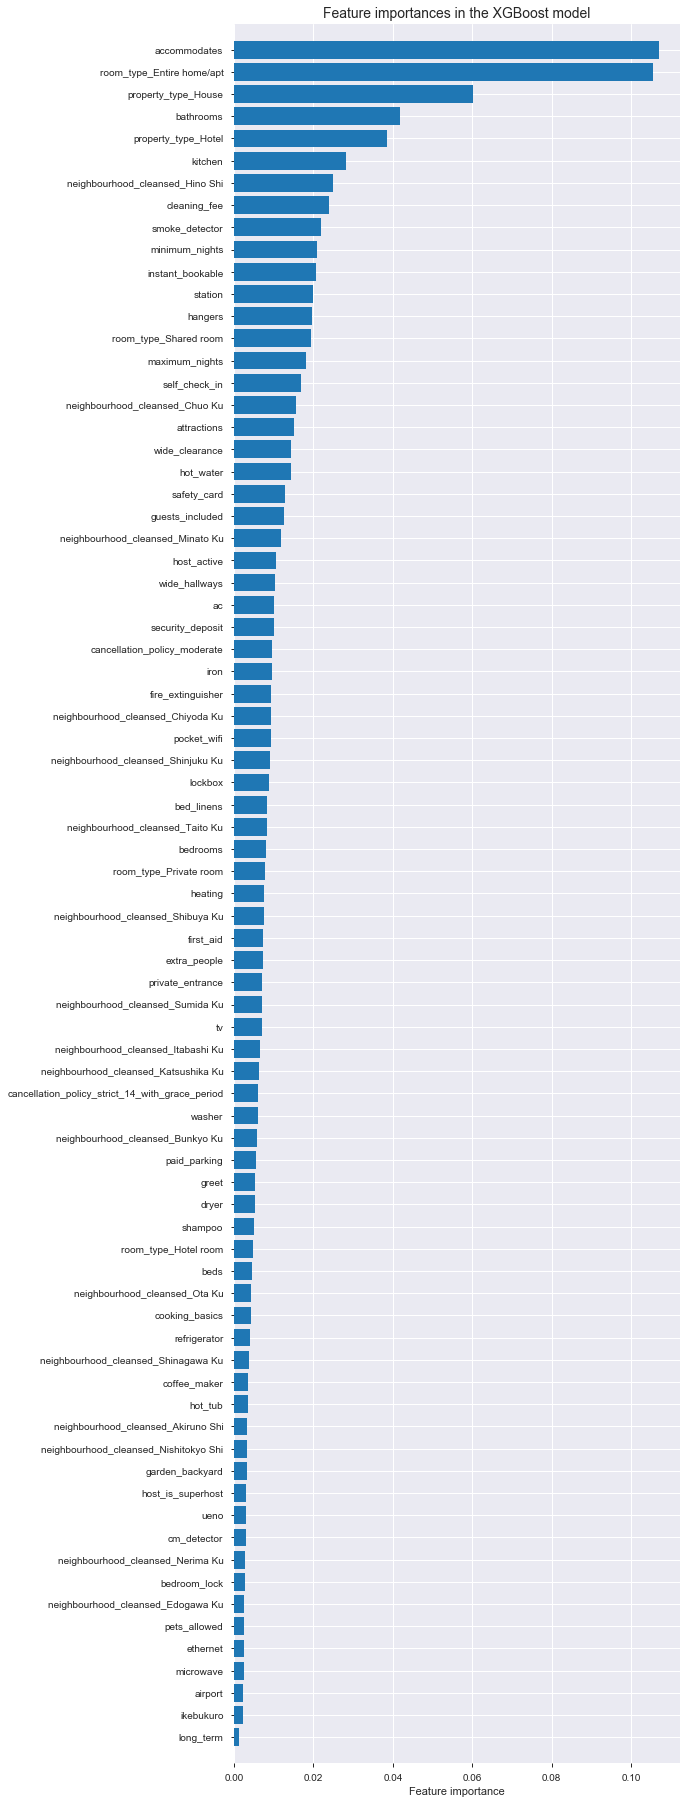

In [23]:
# Plotting feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(8,32))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

### Lets use availability_30 as Target

In [ ]:
# #Target
# y_30 = df['availability_30']
# X_30 = df.drop(['availability_30','availability_90'],axis=1)

In [ ]:
# X_30 = pd.DataFrame(scaler.fit_transform(X_30), columns=list(X_30.columns))
# X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X_30, y_30, test_size=0.2, random_state=42)

In [ ]:
# xgb_reg = xgb.XGBRegressor()
# xgb_reg.fit(X_train_30, y_train_30)
# training_preds_xgb_reg = xgb_reg.predict(X_train_30)
# val_preds_xgb_reg = xgb_reg.predict(X_test_30)

# print("\nTraining MSE:", round(mean_squared_error(y_train_30, training_preds_xgb_reg),3))
# print("Validation MSE:", round(mean_squared_error(y_test_30, val_preds_xgb_reg),3))

In [ ]:
# ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train_30.columns)
# ft_weights_xgb_reg.sort_values('weight', inplace=True)

In [ ]:
# # Drop feature weights of 0 
# ft_weights_xgb_reg = ft_weights_xgb_reg[(ft_weights_xgb_reg != 0).all(1)]

In [ ]:
# # Plotting feature importances
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8,30))
# plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
# plt.title("Feature importances in the XGBoost model", fontsize=14)
# plt.xlabel("Feature importance")
# plt.margins(y=0.01)
# plt.show()

### Availability_30 has a bigger MSE. 

### Lets use availability_90 as the Target

In [ ]:
# #Target
# y_90 = df['availability_90']
# X_90 = df.drop(['availability_30','availability_90'],axis=1)

# X_90 = pd.DataFrame(scaler.fit_transform(X_90), columns=list(X_90.columns))
# X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X_90, y_90, test_size=0.2, random_state=42)

# xgb_reg = xgb.XGBRegressor()
# xgb_reg.fit(X_train_90, y_train_90)
# training_preds_xgb_reg = xgb_reg.predict(X_train_90)
# val_preds_xgb_reg = xgb_reg.predict(X_test_90)

# print("\nTraining MSE:", round(mean_squared_error(y_train_90, training_preds_xgb_reg),3))
# print("Validation MSE:", round(mean_squared_error(y_test_90, val_preds_xgb_reg),3))

# ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train_90.columns)
# ft_weights_xgb_reg.sort_values('weight', inplace=True)
# # Drop feature weights of 0 
# ft_weights_xgb_reg = ft_weights_xgb_reg[(ft_weights_xgb_reg != 0).all(1)]

# # Plotting feature importances
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8,30))
# plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
# plt.title("Feature importances in the XGBoost model", fontsize=14)
# plt.xlabel("Feature importance")
# plt.margins(y=0.01)
# plt.show()

### Availability_90 has a huge MSE. 

## Neural Net

In [24]:
from keras import models, layers, optimizers, regularizers

Using TensorFlow backend.


### Build Model without regularizers

In [25]:
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(
                                                           X_price, y_price, test_size=0.2, random_state=42)

In [26]:
# Building the model
nn = models.Sequential()
nn.add(layers.Dense(128, input_shape=(X_train_price.shape[1],), activation='relu'))
nn.add(layers.Dense(256, activation='relu'))
nn.add(layers.Dense(256, activation='relu'))
nn.add(layers.Dense(512, activation='relu'))
nn.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               20608     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 251,521
Trainable params: 251,521
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
# Training the model
nn_history = nn.fit(X_train_price,
                  y_train_price,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

Train on 8636 samples, validate on 960 samples
Epoch 1/150
8636/8636 [==============================] - 1s 59us/step - loss: 21.9491 - mean_squared_error: 21.9491 - val_loss: 4.0123 - val_mean_squared_error: 4.0123
Epoch 2/150
8636/8636 [==============================] - 0s 50us/step - loss: 3.3523 - mean_squared_error: 3.3523 - val_loss: 1.7592 - val_mean_squared_error: 1.7592
Epoch 3/150
8636/8636 [==============================] - 0s 38us/step - loss: 1.2228 - mean_squared_error: 1.2228 - val_loss: 1.1957 - val_mean_squared_error: 1.1957
Epoch 4/150
8636/8636 [==============================] - 0s 31us/step - loss: 0.7385 - mean_squared_error: 0.7385 - val_loss: 1.0026 - val_mean_squared_error: 1.0026
Epoch 5/150
8636/8636 [==============================] - 0s 34us/step - loss: 0.5456 - mean_squared_error: 0.5456 - val_loss: 0.8877 - val_mean_squared_error: 0.8877
Epoch 6/150
8636/8636 [==============================] - 0s 32us/step - loss: 0.4413 - mean_squared_error: 0.4413 - val_l

Epoch 50/150
8636/8636 [==============================] - 0s 31us/step - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.4558 - val_mean_squared_error: 0.4558
Epoch 51/150
8636/8636 [==============================] - 0s 30us/step - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.4469 - val_mean_squared_error: 0.4469
Epoch 52/150
8636/8636 [==============================] - 0s 30us/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.4557 - val_mean_squared_error: 0.4557
Epoch 53/150
8636/8636 [==============================] - 0s 31us/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.4430 - val_mean_squared_error: 0.4430
Epoch 54/150
8636/8636 [==============================] - 0s 30us/step - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.4568 - val_mean_squared_error: 0.4568
Epoch 55/150
8636/8636 [==============================] - 0s 30us/step - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.4513 - val_mean_squared_error: 0.451

8636/8636 [==============================] - 0s 43us/step - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.4095 - val_mean_squared_error: 0.4095
Epoch 100/150
8636/8636 [==============================] - 0s 37us/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.4004 - val_mean_squared_error: 0.4004
Epoch 101/150
8636/8636 [==============================] - 0s 40us/step - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.4037 - val_mean_squared_error: 0.4037
Epoch 102/150
8636/8636 [==============================] - 0s 35us/step - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.4028 - val_mean_squared_error: 0.4028
Epoch 103/150
8636/8636 [==============================] - 0s 36us/step - loss: 0.0194 - mean_squared_error: 0.0194 - val_loss: 0.4092 - val_mean_squared_error: 0.4092
Epoch 104/150
8636/8636 [==============================] - 0s 37us/step - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.4099 - val_mean_squared_error: 0.4099
Epoch 

Epoch 148/150
8636/8636 [==============================] - 0s 51us/step - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 0.3750 - val_mean_squared_error: 0.3750
Epoch 149/150
8636/8636 [==============================] - 0s 52us/step - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.3568 - val_mean_squared_error: 0.3568
Epoch 150/150
8636/8636 [==============================] - 0s 37us/step - loss: 0.0276 - mean_squared_error: 0.0276 - val_loss: 0.3708 - val_mean_squared_error: 0.3708


In [28]:
def nn_model_evaluation(model,X_train, X_test, y_train, y_test, skip_epochs=0,):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()

Training MSE: 0.0599
Validation MSE: 0.3679

Training r2: 0.9251
Validation r2: 0.4902


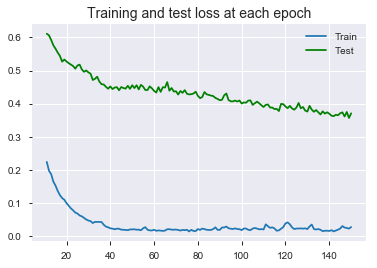

In [29]:
nn_model_evaluation(nn,X_train_price,X_test_price, y_train_price, y_test_price, skip_epochs=10)

### Build Model with regularizers

In [30]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train_price.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn2.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn2.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn2.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               20608     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 513       
Total params: 251,521
Trainable params: 251,521
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
# Training the model
nn2_history = nn2.fit(X_train_price,
                  y_train_price,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

Train on 8636 samples, validate on 960 samples
Epoch 1/150
8636/8636 [==============================] - 1s 63us/step - loss: 79.3449 - mean_squared_error: 19.7138 - val_loss: 57.6970 - val_mean_squared_error: 3.5085
Epoch 2/150
8636/8636 [==============================] - 0s 38us/step - loss: 52.2075 - mean_squared_error: 2.8430 - val_loss: 45.7533 - val_mean_squared_error: 1.2329
Epoch 3/150
8636/8636 [==============================] - 0s 42us/step - loss: 42.0470 - mean_squared_error: 1.1442 - val_loss: 38.4216 - val_mean_squared_error: 0.9603
Epoch 4/150
8636/8636 [==============================] - 1s 60us/step - loss: 35.5658 - mean_squared_error: 0.7046 - val_loss: 33.1240 - val_mean_squared_error: 0.8261
Epoch 5/150
8636/8636 [==============================] - 0s 44us/step - loss: 30.8117 - mean_squared_error: 0.5552 - val_loss: 28.9458 - val_mean_squared_error: 0.7511
Epoch 6/150
8636/8636 [==============================] - 0s 44us/step - loss: 26.9631 - mean_squared_error: 0.46

Epoch 50/150
8636/8636 [==============================] - 0s 50us/step - loss: 0.7810 - mean_squared_error: 0.3128 - val_loss: 0.9141 - val_mean_squared_error: 0.4558
Epoch 51/150
8636/8636 [==============================] - 0s 52us/step - loss: 0.7592 - mean_squared_error: 0.3100 - val_loss: 0.8969 - val_mean_squared_error: 0.4587
Epoch 52/150
8636/8636 [==============================] - 0s 45us/step - loss: 0.7438 - mean_squared_error: 0.3099 - val_loss: 0.8806 - val_mean_squared_error: 0.4554
Epoch 53/150
8636/8636 [==============================] - 0s 46us/step - loss: 0.7269 - mean_squared_error: 0.3075 - val_loss: 0.8704 - val_mean_squared_error: 0.4571
Epoch 54/150
8636/8636 [==============================] - 0s 43us/step - loss: 0.7171 - mean_squared_error: 0.3095 - val_loss: 0.8455 - val_mean_squared_error: 0.4456
Epoch 55/150
8636/8636 [==============================] - 0s 48us/step - loss: 0.6977 - mean_squared_error: 0.3038 - val_loss: 0.8335 - val_mean_squared_error: 0.448

8636/8636 [==============================] - 0s 42us/step - loss: 0.5585 - mean_squared_error: 0.2783 - val_loss: 0.7125 - val_mean_squared_error: 0.4332
Epoch 100/150
8636/8636 [==============================] - 0s 42us/step - loss: 0.5600 - mean_squared_error: 0.2800 - val_loss: 0.7167 - val_mean_squared_error: 0.4373
Epoch 101/150
8636/8636 [==============================] - 0s 48us/step - loss: 0.5629 - mean_squared_error: 0.2803 - val_loss: 0.7218 - val_mean_squared_error: 0.4389
Epoch 102/150
8636/8636 [==============================] - 0s 42us/step - loss: 0.5606 - mean_squared_error: 0.2793 - val_loss: 0.7374 - val_mean_squared_error: 0.4524
Epoch 103/150
8636/8636 [==============================] - 0s 44us/step - loss: 0.5621 - mean_squared_error: 0.2784 - val_loss: 0.7116 - val_mean_squared_error: 0.4318
Epoch 104/150
8636/8636 [==============================] - 0s 40us/step - loss: 0.5555 - mean_squared_error: 0.2762 - val_loss: 0.7157 - val_mean_squared_error: 0.4369
Epoch 

Epoch 148/150
8636/8636 [==============================] - 0s 49us/step - loss: 0.5409 - mean_squared_error: 0.2646 - val_loss: 0.7081 - val_mean_squared_error: 0.4328
Epoch 149/150
8636/8636 [==============================] - 1s 60us/step - loss: 0.5433 - mean_squared_error: 0.2677 - val_loss: 0.7018 - val_mean_squared_error: 0.4254
Epoch 150/150
8636/8636 [==============================] - 0s 49us/step - loss: 0.5457 - mean_squared_error: 0.2672 - val_loss: 0.7125 - val_mean_squared_error: 0.4327


Training MSE: 0.2723
Validation MSE: 0.2649

Training r2: 0.6593
Validation r2: 0.6329


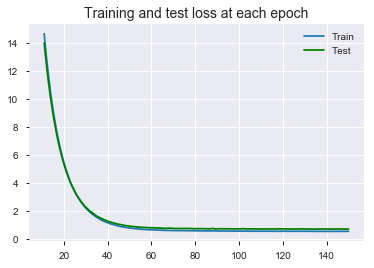

In [32]:
nn_model_evaluation(nn2,X_train_price,X_test_price, y_train_price, y_test_price, skip_epochs=10)

### Neural Net with Kernal Regularizers is best performing with lowest MSE and higest R2 score. 

In [ ]:
# import pickle 

# # Pickle the darn thing! 🥒
# model_name = '/Users/karthikmahendra/Desktop/AirBnB/ABB.pkl' # path to where you want the file
# pickle.dump(xgb_reg, open(model_name, 'wb')) # kitty = the name of your model 

# loaded_model = pickle.load(open(model_name, 'rb'))
# result = loaded_model.score(X_tst, y_tst)
# print(result)

### XGB_Model Prediction

In [34]:
X_tst = X_train_price[:1]
y_tst = y_train_price[:1]

In [37]:
result = np.exp(xgb_reg.predict(X_tst))

In [38]:
result

array([7289.7544], dtype=float32)

In [40]:
np.exp(y_tst)

6906    6021.0
Name: price, dtype: float64

### Neural Net Prediction

In [41]:
result = np.exp(nn2.predict(X_tst))

In [42]:
result

array([[5838.214]], dtype=float32)

In [45]:
np.exp(y_tst)

6906    6021.0
Name: price, dtype: float64